# Segmenting images from a dataset

This notebook demonstrates how pretrained models can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects.

In the future, Streetscapes may include bespoke models trained on specific tasks, such as detecting materials in images and video.

## Setup

Import all the packages that we will need below and set up some convenience variables.

In [98]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
from copy import deepcopy

# --------------------------------------
from PIL import Image

# --------------------------------------
import ibis

# --------------------------------------
from rich import print as pp

# --------------------------------------
import numpy as np

# --------------------------------------
import matplotlib.pyplot as plt

# --------------------------------------
import streetscapes as scs

Load a data file.

In [99]:
amsterdam_side = scs.conf.PARQUET_DIR / "amsterdam_side.parquet"

We will first process one image (chosen at random from the dataset we loaded above) in order to understand how the pipeline works.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

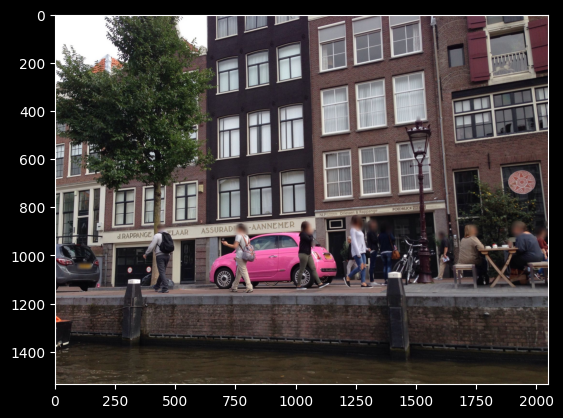

In [100]:
sample_id = ibis.read_parquet(amsterdam_side).to_pandas().sample(1)["orig_id"].values[0]
sample_image = scs.conf.IMAGE_DIR / f"{sample_id}.jpeg"
img_data = np.array(Image.open(sample_image))
plt.imshow(img_data)

We define some categories of objects that we would like to extract. The categories can be defined hierarchically so that categories deeper in the hierarchy would be 'subtracted' from their parents ones. For instance, this can be used to instruct the model to extract 'building' objects _without_ 'window' or 'door' objects. This example is used below.

In [101]:
labels = {
    "sky": None,
    "building": {
        "window": None,
        "door": None,
    },
    "tree": None,
    "car": None,
    "truck": None,
    "road": None,
}

## MaskFormer

First, we will use the MaskFormer model for segmentation. This model is built on the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [102]:
maskformer = scs.models.MaskFormer()

Segment the image and extract some metadata (object instances, colour statistics, latitude and longitude...).

In [103]:
images, segmentations = maskformer.segment(sample_image, labels)

Streetscapes | 2025-02-21@18:36:01 | Segmenting images...
Streetscapes | 2025-02-21@18:36:01 | Detecting objects...
Streetscapes | 2025-02-21@18:36:05 | [ 207197754299357.jpeg ] Extracted 25 instances for 12 labels.


In [ ]:
mf_metadata = maskformer.extract_metadata(images, segmentations)

Streetscapes | 2025-02-21@18:36:05 | Extracting metadata...


100%|██████████| 25/25 [00:00<00:00, 32.81it/s]


Get the metadata for the first (and, in this case, only) image.

In [109]:
seg = deepcopy(segmentations[0])
seg

{'orig_id': 207197754299357,
 'mask': array([[ 5,  5,  5, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  2,  2,  2],
        ...,
        [16, 16, 16, ..., 16, 16, 16],
        [16, 16, 16, ..., 16, 16, 16],
        [16, 16, 16, ..., 16, 16, 16]], shape=(1536, 2048), dtype=int32),
 'instances': {1: 'person',
  2: 'building',
  3: 'pole',
  4: 'person',
  5: 'sky',
  6: 'person',
  7: 'pole',
  8: 'wall',
  9: 'person',
  10: 'sidewalk',
  11: 'person',
  12: 'person',
  13: 'car',
  14: 'person',
  15: 'person',
  16: 'water',
  17: 'billboard',
  18: 'bicycle',
  19: 'person',
  20: 'vegetation',
  21: 'street-light',
  22: 'billboard',
  23: 'car',
  24: 'person',
  25: 'pole'}}

## Visualisation

Select a few labels of interest. Only these labels will be highlighted in the visualisation.

In [107]:
highlight = {"building", "sky", "road", "window"}

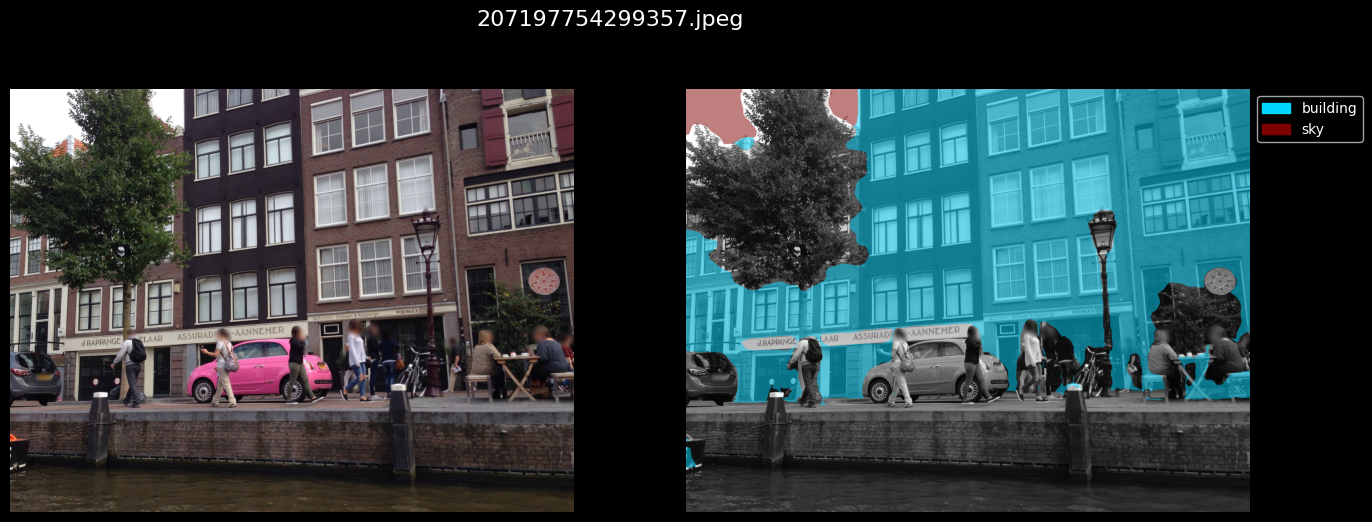

In [110]:
(fig, ax) = maskformer.visualise_segmentation(images[0], seg, highlight, title=sample_image.name)

## Process multiple entries from the dataset at once

The segmentation model also provides a convenience method to process multiple images in a subset of the `streetscapes` dataset at once. We will use the `sample` method to extract a small subset of 10 images of the dataset. Those images will be segmented, and the metadata (statistics about the colour of the detected instances, instance masks, latitude and longitude of the place where the image was taken, and so forth) will be stored in a separate Parquet file for each image, with the same name as the image itself (and the extension `.parquet`) in the same directory as the image. This would allow us to segment a large dataset once and later load the results from the individual `parquet` files.

In [111]:
(images, segmentations) = maskformer.segment_from_dataset(amsterdam_side, labels, sample=10)

Streetscapes | 2025-02-21@18:53:10 | Segmenting images...
Streetscapes | 2025-02-21@18:53:10 | Detecting objects...
Streetscapes | 2025-02-21@18:53:50 | [ 575246277100971.jpeg ] Extracted 9 instances for 7 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 362880593.jpeg ] Extracted 13 instances for 12 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 804592297136095.jpeg ] Extracted 2 instances for 2 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 179539890692913.jpeg ] Extracted 14 instances for 12 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 724547928995642.jpeg ] Extracted 22 instances for 10 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 499100334565243.jpeg ] Extracted 23 instances for 14 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 8356720.jpeg ] Extracted 31 instances for 21 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 835419317105684.jpeg ] Extracted 12 instances for 9 labels.
Streetscapes | 2025-02-21@18:53:50 | [ 834864040722099.jpeg ] Extracted 24 instances for 14 labels.
Str

In [ ]:
mf_meta_multi = maskformer.extract_metadata(images, segmentations)

Streetscapes | 2025-02-21@18:57:21 | Extracting metadata...


100%|██████████| 11/11 [00:00<00:00, 13.34it/s]


Get the path and the metadata for the first image.

In [112]:
seg = segmentations[0]
seg

{'orig_id': 575246277100971,
 'mask': array([[1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]], shape=(1536, 2048), dtype=int32),
 'instances': {1: 'building',
  2: 'bicycle',
  3: 'curb',
  4: 'sky',
  5: 'sidewalk',
  6: 'person',
  7: 'bicycle',
  8: 'road',
  9: 'bicycle'}}

The metadata file is stored in a Parquet file with the same name and path as the image, with the extension `.parquet`.

The statistics can be loaded back into a dictionary format from the Parquet file. We will visualise the segmentation with the original (computed) metadata and with the loaded metadata to ensure that they are identical.

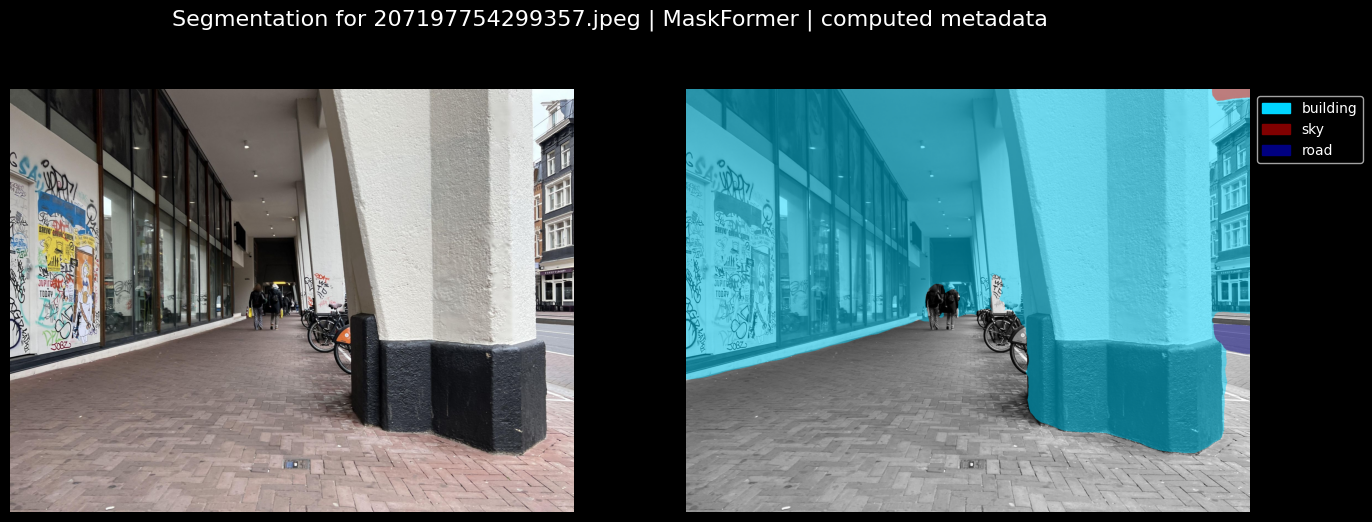

In [114]:
(fig, ax) = maskformer.visualise_segmentation(
    images[0],
    seg,
    highlight,
    title=f"Segmentation for {sample_image.name} | MaskFormer | computed metadata",
)

In [124]:
metadata_path = maskformer.save_metadata(segmentations, mf_meta_multi, scs.conf.PARQUET_DIR / "test-multiple.parquet")

In [131]:
loaded_seg, loaded_meta = maskformer.load_metadata(metadata_path)

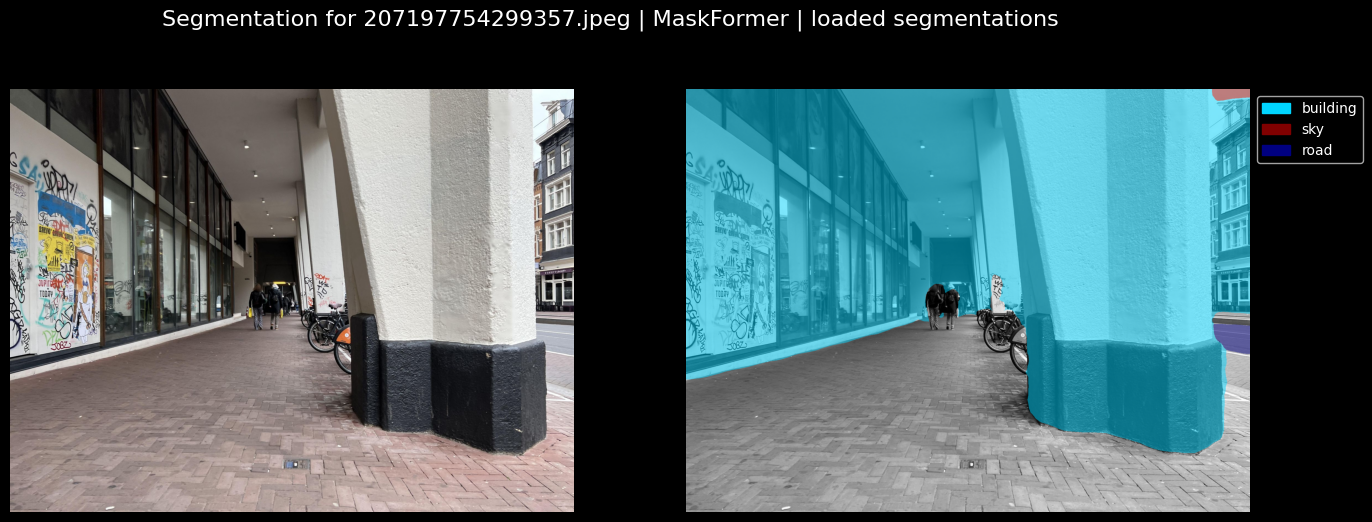

In [133]:
(fig, ax) = maskformer.visualise_segmentation(
    images[0],
    loaded_seg[0],
    highlight,
    title=f"Segmentation for {sample_image.name} | MaskFormer | loaded segmentations",
)

## DinoSAM

Next, we will apply the same pipeline to another model: `DinoSAM`. The implementation of DinoSAM was insipred heavily by two existing projects: [Language Segment-Anything (LangSAM)](https://github.com/luca-medeiros/lang-segment-anything?tab=readme-ov-file) and [SamGeo](https://samgeo.gishub.org/).

In a nutshell, DinoSAM uses the [`GroundingDINO`](https://huggingface.co/IDEA-Research/grounding-dino-base) for object detection and labelling and [`SAM2`](https://github.com/facebookresearch/sam2) models for semantic segmentation. The result is a model tha can segment images into instances of objects requested via a **textual prompt**.

In [134]:
ds_model = scs.models.DinoSAM()

We will use the same dataset as the MaskFormer model.

In [171]:
images, segmentations = ds_model.segment(sample_image, labels)

Streetscapes | 2025-02-21@19:56:58 | [ 207197754299357 ] Detecting objects...
Streetscapes | 2025-02-21@19:57:06 | [ 207197754299357 ] Performing segmentation...
Streetscapes | 2025-02-21@19:57:17 | Removing overlaps...
Streetscapes | 2025-02-21@19:57:17 | [ 207197754299357 ] Extracted 48 instances for 6 labels.


In [172]:
seg = segmentations[0]

In [173]:
seg

{'orig_id': 207197754299357,
 'mask': array([[44, 44, 44, ..., 42, 42, 42],
        [44, 44, 44, ..., 42, 42, 42],
        [44, 44, 44, ..., 42, 42, 42],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], shape=(1536, 2048), dtype=uint32),
 'instances': {1: 'car',
  2: 'car',
  3: 'window',
  4: 'window',
  5: 'window',
  6: 'window',
  7: 'window',
  8: 'window',
  9: 'window',
  10: 'window',
  11: 'window',
  12: 'window',
  13: 'window',
  14: 'window',
  15: 'window',
  16: 'window',
  17: 'window',
  18: 'window',
  19: 'window',
  20: 'window',
  21: 'window',
  22: 'window',
  23: 'window',
  24: 'window',
  25: 'window',
  26: 'window',
  27: 'window',
  28: 'window',
  29: 'window',
  30: 'window',
  31: 'door',
  32: 'window',
  33: 'door',
  34: 'window',
  35: 'door',
  36: 'window',
  37: 'window',
  38: 'window',
  39: 'tree',
  40: 'tree',
  41: 'window',
  42: 'building',
  43: 'window',
  

Visualise the segmentation

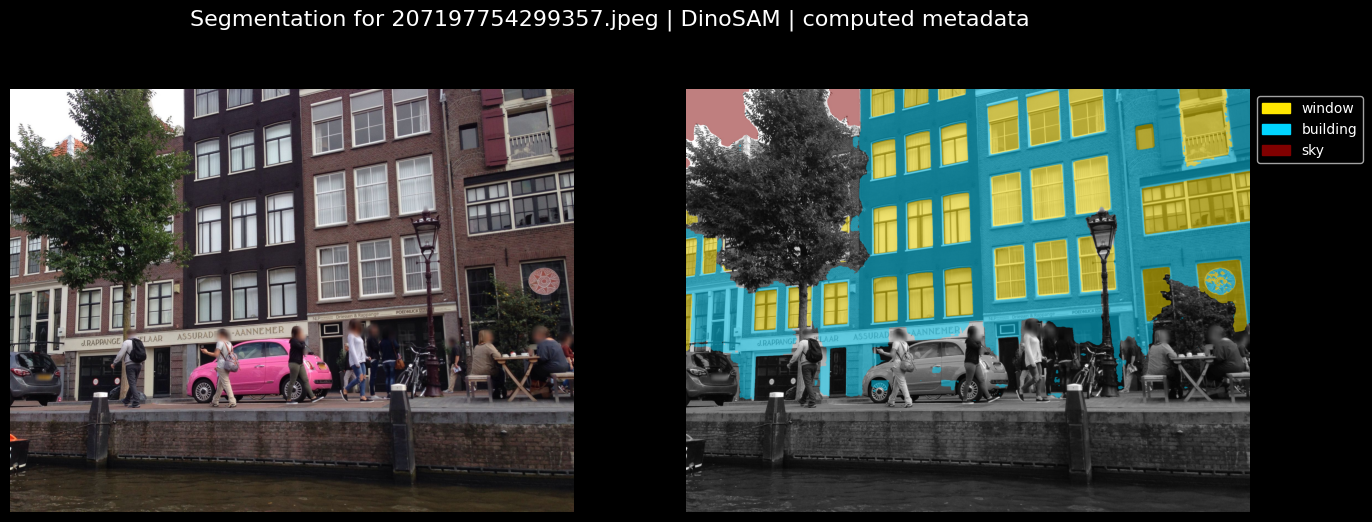

In [174]:
(fig, ax) = ds_model.visualise_segmentation(
    images[0], seg, highlight, title=f"Segmentation for {sample_image.name} | DinoSAM | computed metadata"
)

We can also segment a larger subset of images with DinoSAM.

In [175]:
(images, segmentations) = ds_model.segment_from_dataset(amsterdam_side, labels, sample=3)

Streetscapes | 2025-02-21@19:57:51 | [ 299051551726793 ] Detecting objects...
Streetscapes | 2025-02-21@19:57:59 | [ 299051551726793 ] Performing segmentation...
Streetscapes | 2025-02-21@19:58:10 | Removing overlaps...
Streetscapes | 2025-02-21@19:58:10 | [ 299051551726793 ] Extracted 27 instances for 4 labels.
Streetscapes | 2025-02-21@19:58:10 | [ 955131491898158 ] Detecting objects...
Streetscapes | 2025-02-21@19:58:20 | [ 955131491898158 ] Performing segmentation...
Streetscapes | 2025-02-21@19:58:31 | Removing overlaps...
Streetscapes | 2025-02-21@19:58:31 | [ 955131491898158 ] Extracted 23 instances for 7 labels.
Streetscapes | 2025-02-21@19:58:31 | [ 770469410584120 ] Detecting objects...
Streetscapes | 2025-02-21@19:58:40 | [ 770469410584120 ] Performing segmentation...
Streetscapes | 2025-02-21@19:58:50 | Removing overlaps...
Streetscapes | 2025-02-21@19:58:50 | [ 770469410584120 ] Extracted 20 instances for 7 labels.


In [176]:
metadata = ds_model.extract_metadata(images, segmentations)

Streetscapes | 2025-02-21@19:58:50 | Extracting metadata...


100%|██████████| 20/20 [00:00<00:00, 31.85it/s]


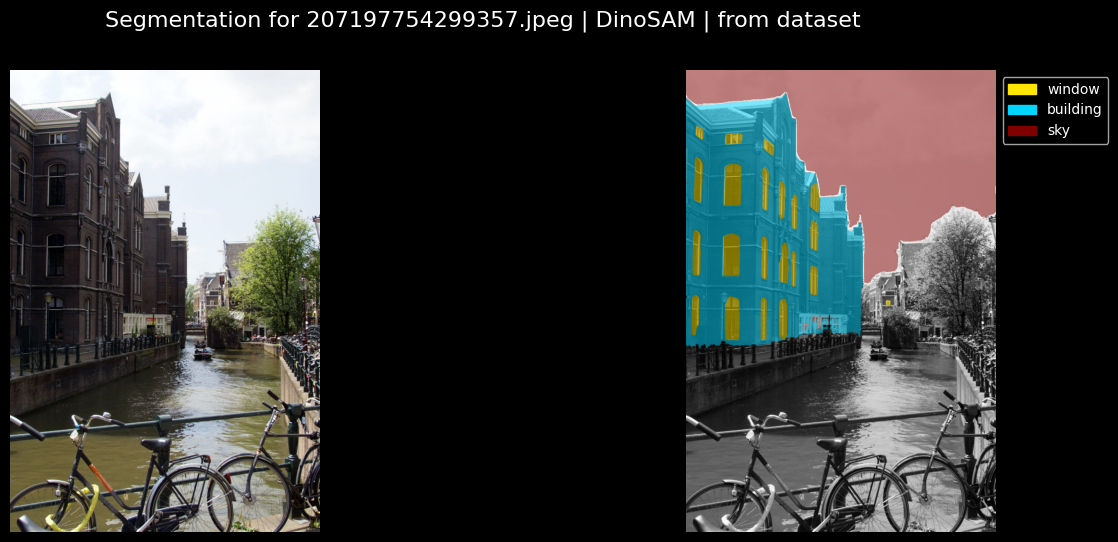

In [177]:
(fig, ax) = ds_model.visualise_segmentation(
    images[0],
    segmentations[0],
    highlight,
    title=f"Segmentation for {sample_image.name} | DinoSAM | from dataset",
)